<a href="https://colab.research.google.com/github/zsjgithub654/590DV-Final-Project/blob/master/CNN/smote/CNN_training_smote_no_callback_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script can be run with TPU (or GPU), which is 10 times faster than training with CPU. However the free version usage is limited by Colab (once run, cannot be used for at least the following 2 days), so use TPU only when necessary.

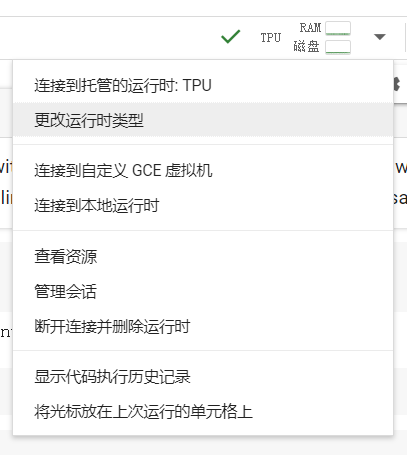

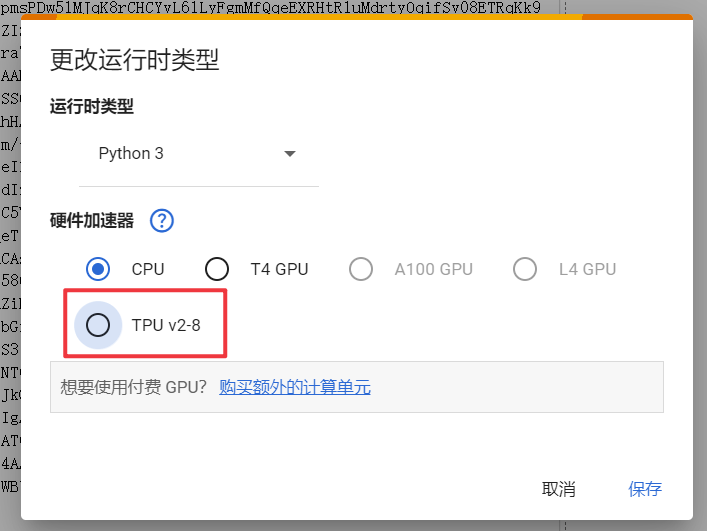

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define variable for path construction

In [2]:
# to construct the path string
method_name = "smote"
x_input_path = "/content/drive/MyDrive/870/Dataset/imbalance/smote/X_train_smote.npy"
y_input_path = "/content/drive/MyDrive/870/Dataset/imbalance/smote/y_train_smote.npy"
output_path = '/content/drive/MyDrive/870/Model/'

# Load data
train set, numpy file format.

x: 150 * 150 * 3

y: 25 * sample num

In [3]:
import numpy as np

X_train = np.load(x_input_path)
y_train_matrix = np.load(y_input_path)

In [4]:
print(X_train.shape)
print(y_train_matrix.shape)

(51600, 150, 150, 3)
(51600, 25)


# Train model
Skip to evaluation if already have the model file.

model trained with TPU using tensorflow 2.15.0 (keras 2.15.0). But free TPU  runtime usage is limited by Colab. CPU runtime is using tensorflow 2.17.0 (keras 3.4.1), model files saved from this version cannot be loadded by keras 3, so either update tensorflow and keras for TPU environ. Or install lower version on CPU environment.

Note the versions of these two have to be compatible (tensorflow 2.15.0 - keras 2.15.0 or tensorflow 2.17.0 - keras 3.4.1).

In [5]:
!pip install keras==3.4.1

In [6]:
!pip install tensorflow==2.17.0

In [7]:
import keras
import tensorflow
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [8]:
print(keras.__version__)
print(tensorflow.__version__)

3.4.1
2.17.0


### Use GPU strategy to speed up training

In [9]:
device_name = tensorflow.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# define model
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(150,150,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(25, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy',
                optimizer = Adam(learning_rate=0.0001),
                metrics=['accuracy'])
    return Malware_model


# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

The model architecture is consistent with the one in paper:

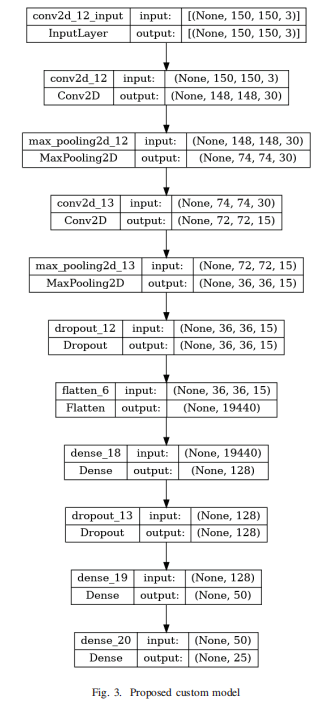

## Train without callbacks
The paper use callbacks to changes learning rate and the epoch to stop at runtime to avoid overfitting, but it might introduce variation among different groups.

In [11]:
with tensorflow.device('/device:GPU:0'):
  model = malware_model()

# show model architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 30)        │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 30)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 15)          │           4,065 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 15)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36, 36, 15)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 19440)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,488,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           6,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,501,078 (9.54 MB)

 Trainable params: 2,501,078 (9.54 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.fit(
    x=X_train,  # Training data
    y=y_train_matrix,  # Training labels, need to be one hot encoded
    batch_size=32,  # Batch size of 32
    epochs=100,  # 100 epochs
    # validation_split=0.2, # the callbacks in the paper required validation data
    # callbacks=[reduce_lr, early_stopping]  # Callbacks
)

Epoch 1/100
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9985 - loss: 0.0048
Epoch 2/100
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9990 - loss: 0.0033
Epoch 3/100
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9988 - loss: 0.0037
Epoch 4/100
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9988 - loss: 0.0034
Epoch 5/100
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9991 - loss: 0.0031
Epoch 6/100
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9990 - loss: 0.0033
Epoch 7/100
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9983 - loss: 0.0048
Epoch 8/100
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9989 - loss: 0.0030
Epoch 9/100
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9995 - loss: 0.0024
Epoch 10/100
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9992 - loss: 0.0034
Epoch 11/100
1613/1613 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9994 - loss: 0.0023
Epoch 12/100
1613/1

Save model, the h5 is an old but more commonly used format, save both just in case.

In [14]:
model.save(output_path + "/CNN_" + method_name + "_no_callback_keras3.h5")
model.save(output_path + "/CNN_" + method_name + "_no_callback_keras3.keras")